Mounting drive

In [ ]:
#Mount our google drive
from google.colab import drive
drive.mount('/content/drive')

**Data Preparation**

check if a video is corrupted or not (and delete it if corrupted)

In [2]:
import glob
import cv2
import os

def validate_video(vid_path):
  """
  Checks if a video can be read successfully using OpenCV.

  Args:
      vid_path (str): Path to the video file.

  Returns:
      bool: True if the video can be read, False otherwise.
  """
  cap = cv2.VideoCapture(vid_path)
  success, _ = cap.read()  # Read a single frame
  cap.release()  # Release the capture object
  return success

def delete_corrupted_video(vid_path):
  """
  Deletes a video file if validation fails.

  Args:
      vid_path (str): Path to the video file.
  """
  if not validate_video(vid_path):
    try:
      os.remove(vid_path)
      print(f"Corrupted video deleted: {vid_path}")
    except OSError as e:
      print(f"Error deleting corrupted video {vid_path}: {e}")

video_folders = [
    '/content/drive/My Drive/Deepfake_datasets/Celeb_fake_face_only',
    '/content/drive/My Drive/Deepfake_datasets/Celeb_real_face_only',
    #'/content/drive/My Drive/Deepfake_datasets/DFDC_FAKE_Face_only_data',
    #'/content/drive/My Drive/Deepfake_datasets/DFDC_REAL_Face_only_data',
    #'/content/drive/My Drive/Deepfake_datasets/FF_Face_only_data',
]

video_files = []
for folder in video_folders:
  video_files.extend(glob.glob(os.path.join(folder, "*.mp4")))

print("Total number of videos:", len(video_files))
print("Video files:")
for f in video_files:
  print(f)

count = 0
for video_file in video_files:
  count += 1
  try:
    delete_corrupted_video(video_file)
  except Exception as e:
    print(f"Error processing video {video_file}: {e}")

print(f"Total processed: {count}, Remaining: {len(video_files) - count}")


Total number of videos: 1168
Video files:
/content/drive/My Drive/Deepfake_datasets/Celeb_fake_face_only/id48_id45_0008.mp4
/content/drive/My Drive/Deepfake_datasets/Celeb_fake_face_only/id31_id2_0001.mp4
/content/drive/My Drive/Deepfake_datasets/Celeb_fake_face_only/id42_id47_0003.mp4
/content/drive/My Drive/Deepfake_datasets/Celeb_fake_face_only/id57_id55_0007.mp4
/content/drive/My Drive/Deepfake_datasets/Celeb_fake_face_only/id37_id29_0006.mp4
/content/drive/My Drive/Deepfake_datasets/Celeb_fake_face_only/id38_id29_0001.mp4
/content/drive/My Drive/Deepfake_datasets/Celeb_fake_face_only/id59_id60_0005.mp4
/content/drive/My Drive/Deepfake_datasets/Celeb_fake_face_only/id26_id30_0006.mp4
/content/drive/My Drive/Deepfake_datasets/Celeb_fake_face_only/id37_id17_0001.mp4
/content/drive/My Drive/Deepfake_datasets/Celeb_fake_face_only/id60_id5_0006.mp4
/content/drive/My Drive/Deepfake_datasets/Celeb_fake_face_only/id41_id44_0002.mp4
/content/drive/My Drive/Deepfake_datasets/Celeb_fake_face_

In [3]:
import json
import glob
import numpy as np
import cv2
import copy
import random

def preprocess_video(video_path, preprocessor):
  """
  Preprocesses a video using the provided preprocessor function.

  Args:
      video_path (str): Path to the video file.
      preprocessor (callable): Function that takes a frame and returns a preprocessed frame.

  Yields:
      numpy.ndarray: A preprocessed frame from the video.
  """
  cap = cv2.VideoCapture(video_path)
  success, frame = cap.read()
  while success:
    preprocessed_frame = preprocessor(frame)
    yield preprocessed_frame
    success, frame = cap.read()
  cap.release()

video_folders = [
    '/content/drive/My Drive/Deepfake_datasets/Celeb_fake_face_only',
    '/content/drive/My Drive/Deepfake_datasets/Celeb_real_face_only',

]

video_files = []
for folder in video_folders:
  video_files.extend(glob.glob(os.path.join(folder, "*.mp4")))

random.shuffle(video_files)
random.shuffle(video_files)

frame_counts = []
for video_file in video_files:
  cap = cv2.VideoCapture(video_file)
  if int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) < 100:
    video_files.remove(video_file)
    continue
  frame_counts.append(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))

print("Total number of videos:", len(frame_counts))
print("Average frame per video:", np.mean(frame_counts))

# Define your preprocessor function
def resize_and_normalize(frame):
  """
  Resizes and normalizes a frame to a specific size.

  Args:
      frame (numpy.ndarray): The original frame.

  Returns:
      numpy.ndarray: The preprocessed frame.
  """
  resized_frame = cv2.resize(frame, (224, 224))  # Resize to desired size
  normalized_frame = resized_frame / 255.0  # Normalize to range [0, 1]
  return normalized_frame





Total number of videos: 1168
Average frame per video: 147.95719178082192


load videos and labels from csv

In [4]:
import pandas as pd

video_list_file = "/content/drive/MyDrive/celeb.csv"
data = pd.read_csv(video_list_file)
print("Available columns:", data.columns.tolist())

Available columns: ['file', 'label']


In [5]:
# load the video name and labels from csv
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
class video_dataset(Dataset):
    def __init__(self,video_names,labels,sequence_length = 60,transform = None):
        self.video_names = video_names
        self.labels = labels
        self.transform = transform
        self.count = sequence_length
    def __len__(self):
        return len(self.video_names)
    def __getitem__(self,idx):
        video_path = self.video_names[idx]
        frames = []
        a = int(100/self.count)
        first_frame = np.random.randint(0,a)
        temp_video = video_path.split('/')[-1]
        #print(temp_video)
        label = self.labels.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]
        if(label == 'FAKE'):
          label = 0
        if(label == 'REAL'):
          label = 1
        for i,frame in enumerate(self.frame_extract(video_path)):
          frames.append(self.transform(frame))
          if(len(frames) == self.count):
            break
        frames = torch.stack(frames)
        frames = frames[:self.count]
        #print("length:" , len(frames), "label",label)
        return frames,label
    def frame_extract(self,path):
      vidObj = cv2.VideoCapture(path)
      success = 1
      while success:
          success, image = vidObj.read()
          if success:
              yield image
#plot the image
def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.show()

In [6]:
#count the number of fake and real videos
def number_of_real_and_fake_videos(data_list):
  header_list = ["file","label"]
  lab = pd.read_csv('/content/drive/My Drive/celeb.csv',names=header_list)
  fake = 0
  real = 0
  for i in data_list:
    temp_video = i.split('/')[-1]
    label = lab.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]
    if(label == 'FAKE'):
      fake+=1
    if(label == 'REAL'):
      real+=1
  return real,fake

train :  934
test :  234
TRAIN:  Real: 466  Fake: 468
TEST:  Real: 122  Fake: 112


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


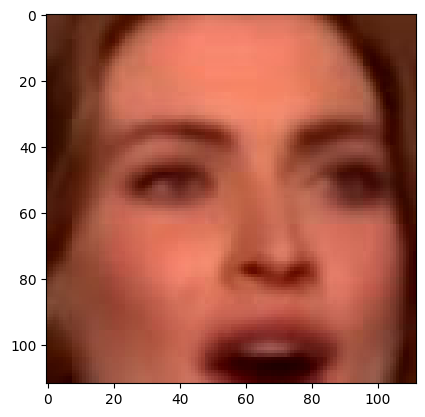

In [7]:
# load the labels and video in data loader
import random
import pandas as pd
from sklearn.model_selection import train_test_split

header_list = ["file","label"]
labels = pd.read_csv('/content/drive/My Drive/celeb.csv',names=header_list)
#print(labels)
train_videos = video_files[:int(0.8*len(video_files))]
valid_videos = video_files[int(0.8*len(video_files)):]
print("train : " , len(train_videos))
print("test : " , len(valid_videos))
# train_videos,valid_videos = train_test_split(data,test_size = 0.2)
# print(train_videos)

print("TRAIN: ", "Real:",number_of_real_and_fake_videos(train_videos)[0]," Fake:",number_of_real_and_fake_videos(train_videos)[1])
print("TEST: ", "Real:",number_of_real_and_fake_videos(valid_videos)[0]," Fake:",number_of_real_and_fake_videos(valid_videos)[1])


im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

test_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
train_data = video_dataset(train_videos,labels,sequence_length = 10,transform = train_transforms)
#print(train_data)
val_data = video_dataset(valid_videos,labels,sequence_length = 10,transform = train_transforms)
train_loader = DataLoader(train_data,batch_size = 4,shuffle = True,num_workers = 4)
valid_loader = DataLoader(val_data,batch_size = 4,shuffle = True,num_workers = 4)
image,label = train_data[0]
im_plot(image[0,:,:,:])

**LSTM model :**


In [8]:
import torch
from torch import nn
from torchvision import models

class Model(nn.Module):
    def __init__(self, num_classes, latent_dim=2048, lstm_layers=1, hidden_dim=2048, bidirectional=False):
        super(Model, self).__init__()
        # Load pretrained ResNeXt model and remove the last two layers
        model = models.resnext50_32x4d(pretrained=True)
        self.model = nn.Sequential(*list(model.children())[:-2])

        # LSTM for temporal feature extraction
        self.lstm = nn.LSTM(latent_dim, hidden_dim, lstm_layers, bidirectional=bidirectional, batch_first=True)

        # LeakyReLU activation
        self.relu = nn.LeakyReLU()

        # Dropout for regularization
        self.dp = nn.Dropout(0.4)

        # Fully connected layer for classification
        self.linear1 = nn.Linear(hidden_dim, num_classes)

        # Adaptive average pooling to reduce feature map dimensions
        self.avgpool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        batch_size, seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)

        # Pass through ResNeXt model
        fmap = self.model(x)

        # Apply adaptive average pooling
        x = self.avgpool(fmap)
        x = x.view(batch_size, seq_length, -1)

        # Pass through LSTM
        x_lstm, _ = self.lstm(x)

        # Mean pooling and classification
        x = torch.mean(x_lstm, dim=1)
        x = self.dp(self.relu(x))
        x = self.linear1(x)

        return fmap, x

if __name__ == "__main__":
    # Define the model
    num_classes = 2  # Example: binary classification (real vs. fake)
    model = Model(num_classes)

    # Example input: batch of 2 videos, each with 10 frames of 3x224x224 images
    example_input = torch.randn(2, 10, 3, 224, 224)

    # Forward pass
    fmap, output = model(example_input)

    # Print output shapes
    print("Feature map shape:", fmap.shape)
    print("Output shape:", output.shape)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 119MB/s]


Feature map shape: torch.Size([20, 2048, 7, 7])
Output shape: torch.Size([2, 2])


In [9]:
model = Model(2)
a,b = model(torch.from_numpy(np.empty((1,20,3,112,112))).type(torch.FloatTensor))


In [10]:
import torch
from torch.autograd import Variable
import time
import os
import sys

def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    t = []
    for i, (inputs, targets) in enumerate(data_loader):
        _, outputs = model(inputs)
        loss = criterion(outputs, targets)
        acc = calculate_accuracy(outputs, targets)
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d / %d] [Loss: %f, Acc: %.2f%%]"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(data_loader),
                    losses.avg,
                    accuracies.avg))
    torch.save(model.state_dict(), '/content/drive/MyDrive/checkpoints/checkpoint.pt')
    return losses.avg, accuracies.avg

def test(epoch, model, data_loader, criterion):
    print('Testing')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    count = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):

            _, outputs = model(inputs)
            loss = torch.mean(criterion(outputs, targets))
            acc = calculate_accuracy(outputs, targets)
            _, p = torch.max(outputs, 1)
            true += targets.detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))
            sys.stdout.write(
                    "\r[Batch %d / %d]  [Loss: %f, Acc: %.2f%%]"
                    % (
                        i,
                        len(data_loader),
                        losses.avg,
                        accuracies.avg
                        )
                    )
        print('\nAccuracy {}'.format(accuracies.avg))
    return true, pred, losses.avg, accuracies.avg

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)

    _, pred = outputs.topk(1, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()
    return 100 * n_correct_elems / batch_size



In [11]:
import seaborn as sn
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    calculated_acc = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+ cm[1][1])
    print("Calculated Accuracy",calculated_acc*100)

In [12]:
def plot_loss(train_loss_avg,test_loss_avg,num_epochs):
  loss_train = train_loss_avg
  loss_val = test_loss_avg
  print(num_epochs)
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
def plot_accuracy(train_accuracy,test_accuracy,num_epochs):
  loss_train = train_accuracy
  loss_val = test_accuracy
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training accuracy')
  plt.plot(epochs, loss_val, 'b', label='validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[Epoch 1/5] [Batch 233 / 234] [Loss: 0.665273, Acc: 58.14%]Testing
[Batch 58 / 59]  [Loss: 0.562786, Acc: 72.65%]
Accuracy 72.64957264957265
[Epoch 2/5] [Batch 233 / 234] [Loss: 0.465835, Acc: 78.80%]Testing
[Batch 58 / 59]  [Loss: 0.412722, Acc: 81.62%]
Accuracy 81.62393162393163
[Epoch 3/5] [Batch 233 / 234] [Loss: 0.333756, Acc: 85.12%]Testing
[Batch 58 / 59]  [Loss: 0.353838, Acc: 83.33%]
Accuracy 83.33333333333333
[Epoch 4/5] [Batch 233 / 234] [Loss: 0.316812, Acc: 87.47%]Testing
Testing
[Batch 58 / 59]  [Loss: 0.407826, Acc: 83.76%]
Accuracy 83.76068376068376

Accuracy 83.76068376068376
[Epoch 5/5] [Batch 233 / 234] [Loss: 0.235136, Acc: 90.47%]Testing
Testing
[Batch 58 / 59]  [Loss: 0.425297, Acc: 82.05%]
Accuracy 82.05128205128206
5

Accuracy 82.05128205128206
5


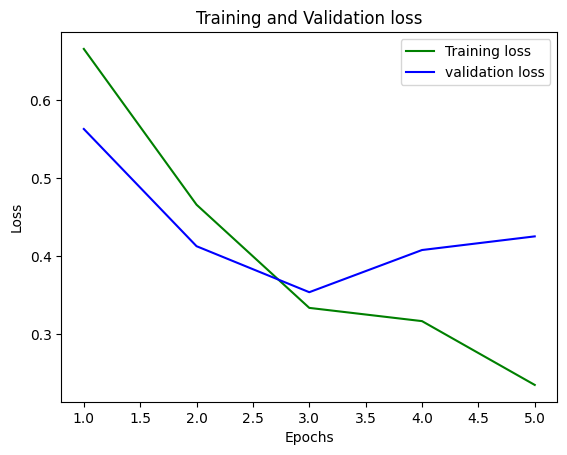

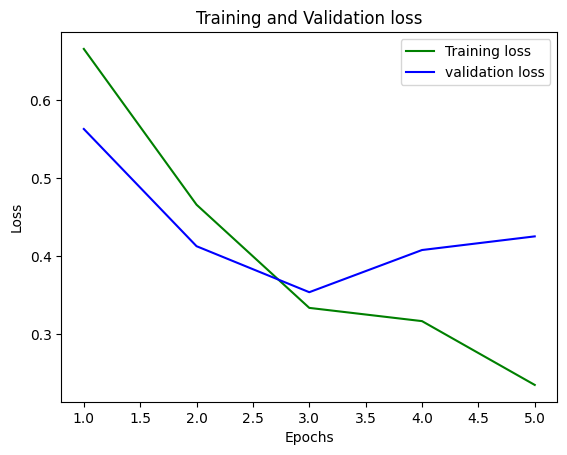

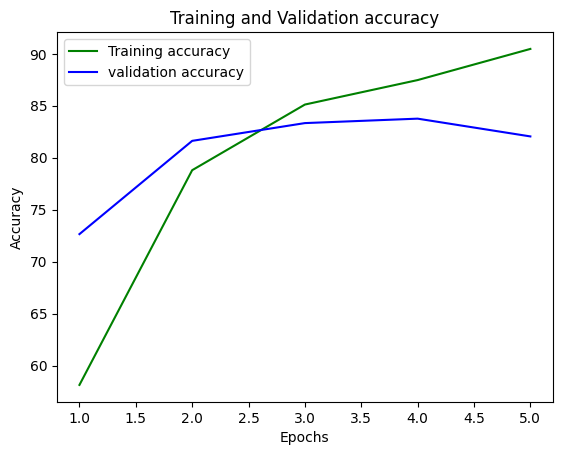

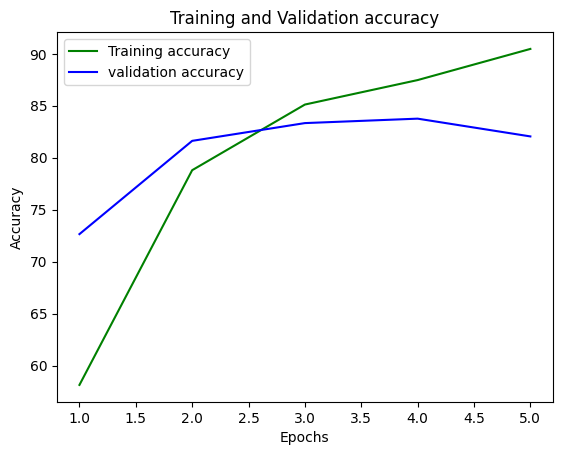

[[101  11]
 [ 31  91]]
True positive =  101
False positive =  11
False negative =  31
True negative =  91


[[101  11]
 [ 31  91]]
True positive =  101
False positive =  11
False negative =  31
True negative =  91




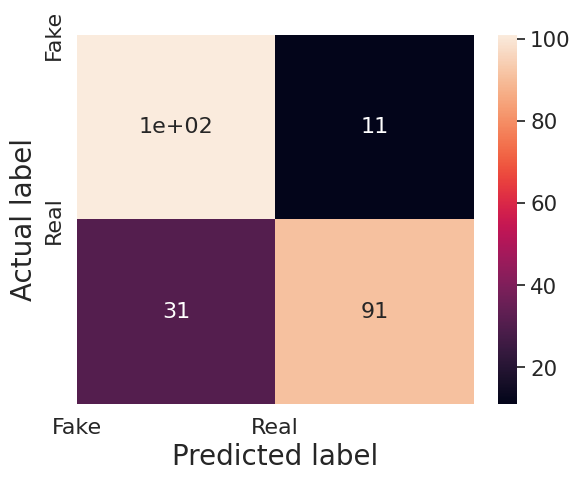

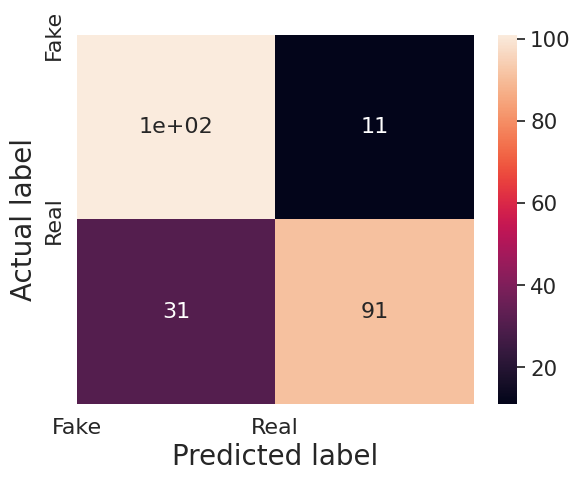

Calculated Accuracy 82.05128205128204
Calculated Accuracy 82.05128205128204


In [13]:
from sklearn.metrics import confusion_matrix

# Learning rate
lr = 1e-5  # 0.001
# Number of epochs
num_epochs = 5

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

# No need for .cuda() as there's no GPU
# criterion = nn.CrossEntropyLoss(weight = class_weights).cuda()
criterion = nn.CrossEntropyLoss()  # Use CPU version of CrossEntropyLoss

train_loss_avg = []
train_accuracy = []
test_loss_avg = []
test_accuracy = []

for epoch in range(1, num_epochs + 1):
    l, acc = train_epoch(epoch, num_epochs, train_loader, model, criterion, optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)



    true, pred, tl, t_acc = test(epoch, model, valid_loader, criterion)
    test_loss_avg.append(tl)
    test_accuracy.append(t_acc)

plot_loss(train_loss_avg, test_loss_avg, len(train_loss_avg))
plot_accuracy(train_accuracy, test_accuracy, len(train_accuracy))
print(confusion_matrix(true, pred))
print_confusion_matrix(true, pred)


^ trained for 5 epochs with celeb data